# SLO Metrics

In [1]:
%reload_ext autoreload
%autoreload 2

import warnings
import math

import sys
sys.path.append('../')
from tsdr import tsdr
from eval import groundtruth
from tsdr.testseries import sockshop
import eval.priorknowledge as pk

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import ruptures as rpt

In [2]:
from meltria import loader

metrics_files = !find /datasets/metrics-hg68n-errors/ -name "*.json" | grep -v network | grep '_0'
dataset, mappings = loader.load_dataset(metrics_files, exclude_middleware_metrics=False)
records = []
for (chaos_type, chaos_comp), sub_df in dataset.groupby(level=[0, 1]):
    for (metrics_file, grafana_dashboard_url), data_df in sub_df.groupby(level=[2, 3]):
        record = loader.DatasetRecord(chaos_type, chaos_comp, metrics_file, data_df)
        records.append(record)

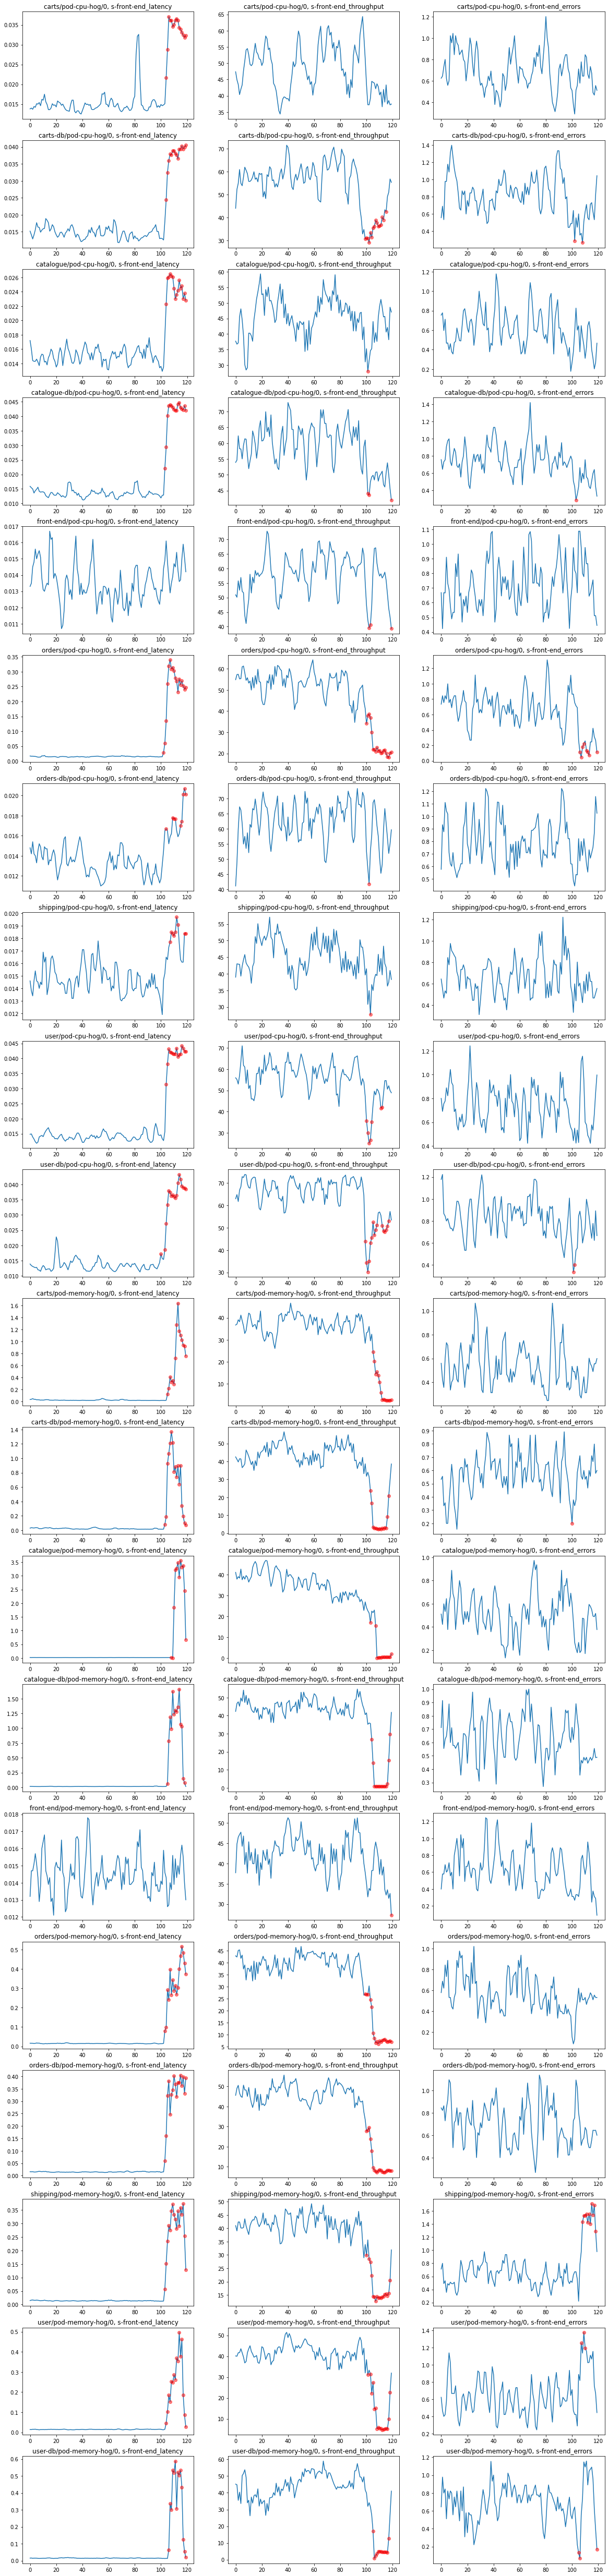

In [24]:
import itertools

fignum: int = len(records) * len(pk.ROOT_METRIC_LABELS)
fig, axs = plt.subplots(math.ceil(fignum/3), ncols=3)
fig.set_size_inches(20, 1.5*fignum)

for (record, label), ax in zip(itertools.product(records, pk.ROOT_METRIC_LABELS), axs.flatten()):
    if label not in record.data_df.columns:
        continue
    slo_metric = record.data_df[label].to_numpy()
    ax.set_title(f"{record.chaos_case_full()}, {label}")
    ax.plot(slo_metric)

    inject_pt = 99
    train, test = np.split(slo_metric, [inject_pt])
    # zscore = scaler.fit_transform(test.reshape(-1, 1))
    mean, sd = train.mean(), train.std()
    threshold = 3
    coeff = scipy.stats.norm.ppf(0.75)-scipy.stats.norm.ppf(0.25)
    iqr = np.quantile(train, 0.75) - np.quantile(train, 0.25)
    niqr = iqr / coeff
    median = np.median(train)

    anomalies = [i for i, v in enumerate(test) if np.abs((v - median)/niqr) > threshold]
    for i in anomalies:
        ax.plot(inject_pt+i, slo_metric[inject_pt+i], 'ro', alpha=0.5)
